# Data Science Capstone Project - The Battle of Neighborhoods (Part 2)

In [134]:
import pandas as pd
import numpy as np
import requests
import geocoder
import folium # map rendering library
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.colors as colors
%matplotlib inline
import os

## define a function to get tlatitude and longitude of a given location using geopy

In [135]:
# function that returns latitude and longitude of a given location using geopy
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

## define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude

In [136]:
# function that returns top 100 venues within 1000 metres of given latitude and longitude
def get_venues(lat,lng): 
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'Y2T54KTNTK3DPWFSIC5QGX3HBZR5FI5CP0IWLHQTLHHLWV4V' # Foursquare ID
    CLIENT_SECRET = '5EAX0XGETHH401KQCZSU2IQDETD4X0W5QWLO0KGNMF11AFGW'# Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    #print(venue)
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df_venue_details = pd.DataFrame(venue_details,columns=column_names)
    return df_venue_details

##  define a function to get venue details like like count , rating , tip counts for a given venue id 

In [137]:
# function that returns venue details(counts , ratings , tip counts
def get_venue_details(venue_id):
    CLIENT_ID = 'Y2T54KTNTK3DPWFSIC5QGX3HBZR5FI5CP0IWLHQTLHHLWV4V' # Foursquare ID
    CLIENT_SECRET = '5EAX0XGETHH401KQCZSU2IQDETD4X0W5QWLO0KGNMF11AFGW' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get the data
    results = requests.get(url).json()["response"]['groups'][0]['items']
    #venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

## define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude

In [138]:
# define a funtion to return the new york city data (Boroughs, Neighborhoods, atitude and longitude)
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define  dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # create dataframe
    df_nyc_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        df_nyc_data = df_nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return df_nyc_data

## call function to get new york data

In [139]:
df_nyc_data = get_new_york_data()
df_nyc_data.shape
df_nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## EDA of neighborhoods in New York City

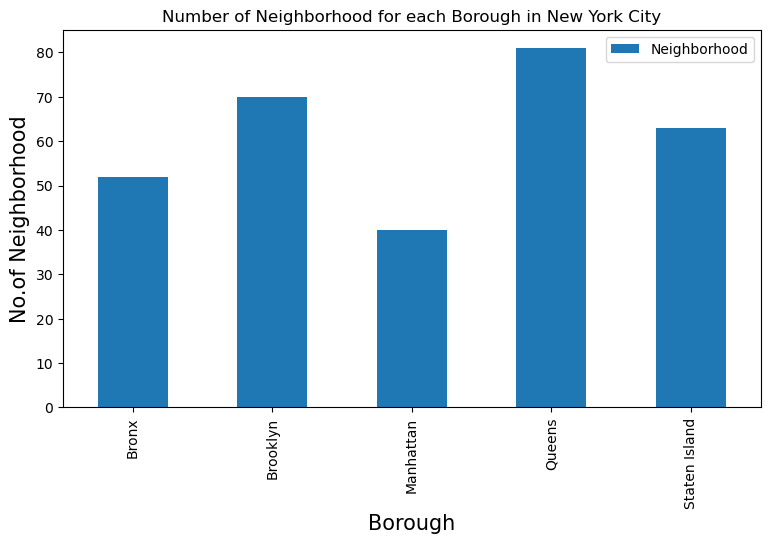

In [140]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
df_nyc_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

# check what the output lookslike for a specific coordinate
tempdf = get_venues(40.894705, -73.847201)
tempdf.head(5)
tempdf[tempdf['Category'].str.contains('Pizza')]
tempdf[tempdf['Category'].str.contains('Italian')]

## we want to search for the finest pizza places in NYC
### We can do that by searching for either pizza places or Intalian restaurants (assuming they all serve pizza)
#### search for a string that contains either pizza or Italian in the category column as above

In [150]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
df_pizza_nyc=pd.DataFrame(columns=column_names)
count=1
for row in df_nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    pizza_resturants=venues[venues['Category'].str.contains('Pizza')]   
    if(count % 10 == 0):
        print('(',count,'/',len(df_nyc_data),')','Pizza Resturants in '+Neighborhood+', '+Borough+':'+str(len(pizza_resturants)))
    for resturant_detail in pizza_resturants.values.tolist():
        id, name , category=resturant_detail
        df_pizza_nyc = df_pizza_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 10 / 306 ) Pizza Resturants in Williamsbridge, Bronx:8
( 20 / 306 ) Pizza Resturants in High  Bridge, Bronx:0
( 30 / 306 ) Pizza Resturants in Country Club, Bronx:4
( 40 / 306 ) Pizza Resturants in Edgewater Park, Bronx:4
( 50 / 306 ) Pizza Resturants in Greenpoint, Brooklyn:5
( 60 / 306 ) Pizza Resturants in Prospect Heights, Brooklyn:2
( 70 / 306 ) Pizza Resturants in Fort Greene, Brooklyn:4
( 80 / 306 ) Pizza Resturants in Bath Beach, Brooklyn:9
( 90 / 306 ) Pizza Resturants in Ocean Hill, Brooklyn:3
( 100 / 306 ) Pizza Resturants in Fort Hamilton, Brooklyn:8
( 110 / 306 ) Pizza Resturants in Lenox Hill, Manhattan:3
( 120 / 306 ) Pizza Resturants in Lower East Side, Manhattan:2
( 130 / 306 ) Pizza Resturants in Astoria, Queens:4
( 140 / 306 ) Pizza Resturants in Long Island City, Queens:3
( 150 / 306 ) Pizza Resturants in College Point, Queens:6
( 160 / 306 ) Pizza Resturants in Briarwood, Queens:6
( 170 / 306 ) Pizza Resturants in Rosedale, Queens:1
( 180 / 306 ) Pizza Resturants

In [154]:
# print(results)
print(count)

307


In [155]:
# get_venues(40.894705,-73.847201)

In [156]:
df_pizza_nyc.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4b6dbb78f964a520968a2ce3,Domino's Pizza
1,Bronx,Wakefield,55aa92ac498e24734cd2e378,Louis Pizza
2,Bronx,Wakefield,4ba10dc5f964a520019337e3,Original Joe's Pizza
3,Bronx,Wakefield,4dc5add8c65b89d3ca7584bb,Original Tony's Pizza
4,Bronx,Co-op City,4d2cfa5cad25224bbbc5fb8f,Capri II Pizza


##  Visualize with a bar plot to see which borough has highest number of Pizza restaurants

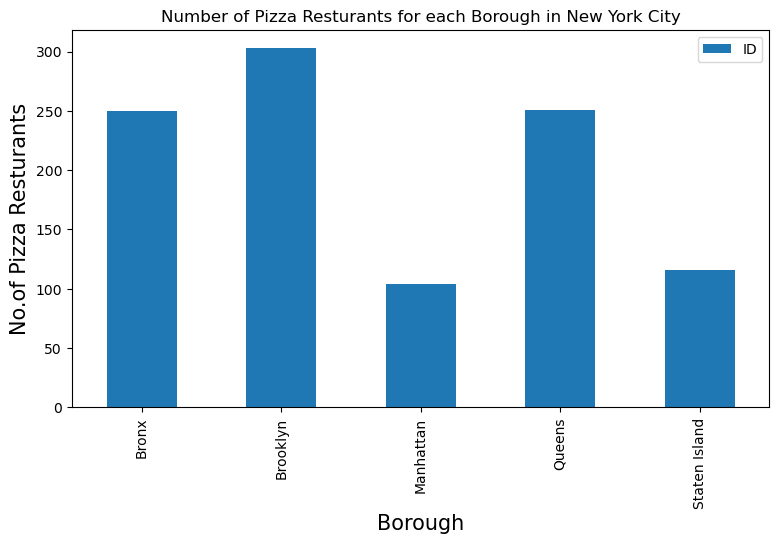

In [157]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Pizza Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Pizza Resturants', fontsize=15)
df_pizza_nyc.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

### Brooklyn has the highest number of pizza restaurants in NYC. 

In [158]:
##  Visualize with a bar plot to see which Neighborhood has highest number of Pizza restaurants

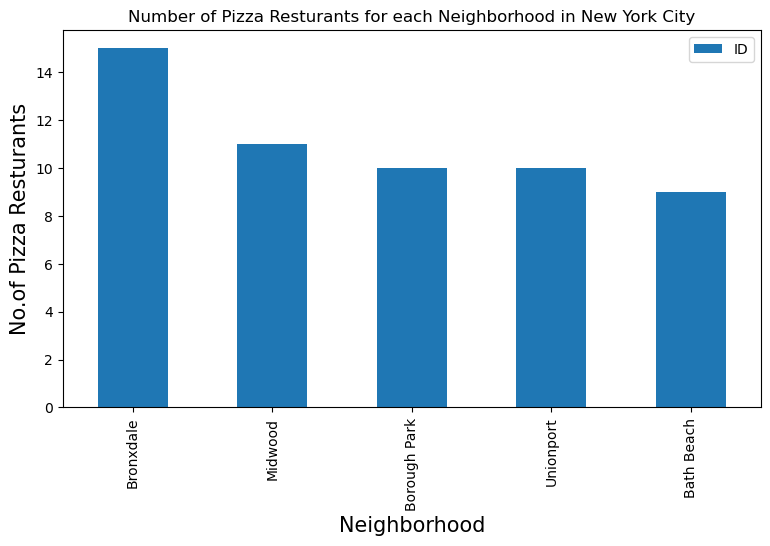

In [159]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Pizza Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Pizza Resturants', fontsize=15)
df_pizza_nyc.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

### find the restaurants in 

### Bronxdale has the highest number of pizza restaurants in NYC.

#### Let's look at the restaurants in Bronxdale.

In [161]:
df_pizza_nyc[df_pizza_nyc['Neighborhood']=='Bronxdale']

,Borough,Neighborhood,ID,Name
990,Bronx,Bronxdale,4bc78c0d0050b71372e8b83b,John & Joe's Pizzeria
991,Bronx,Bronxdale,4b86e7d7f964a5201ea531e3,Sorrento Pizzeria
992,Bronx,Bronxdale,4c8416c747cc224bfa69959f,Pizza Express
993,Bronx,Bronxdale,4b2035e6f964a520bc2e24e3,Emilio's Pizza
994,Bronx,Bronxdale,4e4cf8c3bd413c4cc66da683,Captain's Pizzeria & Restaurant
995,Bronx,Bronxdale,4b67925df964a520ba552be3,Captain's Pizza
996,Bronx,Bronxdale,4b82c608f964a52001e430e3,Morris Park Pizza
997,Bronx,Bronxdale,4e4cf8eebd413c4cc66da7f7,Primavera Pizzeria & Restaurant
998,Bronx,Bronxdale,4c2e5b02452620a16db21b0f,Luciano's Pizza
999,Bronx,Bronxdale,4b48cef8f964a520f55726e3,Venezia Pizzeria


## To make an assessement of the best place to live we need to analyze the rankings of the restaurants

In [220]:
# results

In [222]:
len(results['response']['groups'][0]['items'][45]['venue'])

47

In [236]:
# prepare neighborhood list that contains pizza resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
df_pizza_nyc_stats = pd.DataFrame(columns=column_names)
count=1

for row in df_pizza_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    if(count % 10 == 0):
        print('(',count,'/',len(df_pizza_nyc),')','processed')
    df_pizza_nyc_stats = df_pizza_nyc_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [268]:
df_pizza_nyc_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating
0,Bronx,Wakefield,4b6dbb78f964a520968a2ce3,Domino's Pizza,132.0,7.4
1,Bronx,Wakefield,55aa92ac498e24734cd2e378,Louis Pizza,132.0,7.9
2,Bronx,Wakefield,4ba10dc5f964a520019337e3,Original Joe's Pizza,176.0,4.9
3,Bronx,Wakefield,4dc5add8c65b89d3ca7584bb,Original Tony's Pizza,117.0,9.8
4,Bronx,Co-op City,4d2cfa5cad25224bbbc5fb8f,Capri II Pizza,159.0,5.7


In [240]:
# check data type of columns 
df_pizza_nyc_stats.info()

# convert data types
df_pizza_nyc_stats['Likes']=df_pizza_nyc_stats['Likes'].astype('float64')
df_pizza_nyc_stats['Rating']=df_pizza_nyc_stats['Rating'].astype('float64')
df_pizza_nyc_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 1023
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       1024 non-null   object 
 1   Neighborhood  1024 non-null   object 
 2   ID            1024 non-null   object 
 3   Name          1024 non-null   object 
 4   Likes         2048 non-null   float64
 5   Rating        2048 non-null   float64
dtypes: float64(2), object(4)
memory usage: 112.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 1023
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       1024 non-null   object 
 1   Neighborhood  1024 non-null   object 
 2   ID            1024 non-null   object 
 3   Name          1024 non-null   object 
 4   Likes         2048 non-null   float64
 5   Rating        2048 non-null   float64
dtypes: float64(2), object(4)
memory usage: 11

## Let's find tht top restaurants in NYC

In [241]:
# Resturant with maximum Likes
df_pizza_nyc_stats.iloc[df_pizza_nyc_stats['Likes'].idxmax()]

Borough                            Bronx
Neighborhood          University Heights
ID              4f2c8826e4b056f83a418b53
Name                  Two Grandpas pizza
Likes                                199
Rating                               6.3
Name: 76, dtype: object

In [242]:
# Resturant with maximum Rating
df_pizza_nyc_stats.iloc[df_pizza_nyc_stats['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                   Fieldston
ID              4c6994e3c946e21eb28eea8e
Name                 Salvatore's of Soho
Likes                                135
Rating                               9.9
Name: 12, dtype: object

## Let's find the top neighborhoods (based on restaurants of course)

In [243]:
ny_neighborhood_stats=df_pizza_nyc_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
3,Arrochar,9.90
88,Flatiron,9.80
222,Rosedale,9.80
264,West Village,9.50
45,City Island,9.40
1,Annadale,9.35
195,Pelham Gardens,9.30
173,Neponsit,9.30
66,Downtown,9.30
237,Springfield Gardens,9.00


##  Top boroughs with top average rating of pizza resturants

In [244]:
ny_borough_stats=df_pizza_nyc_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
4,Staten Island,6.305172
1,Brooklyn,6.293729
3,Queens,6.266135
0,Bronx,6.066000
2,Manhattan,6.065385


## Generate a bar chart 

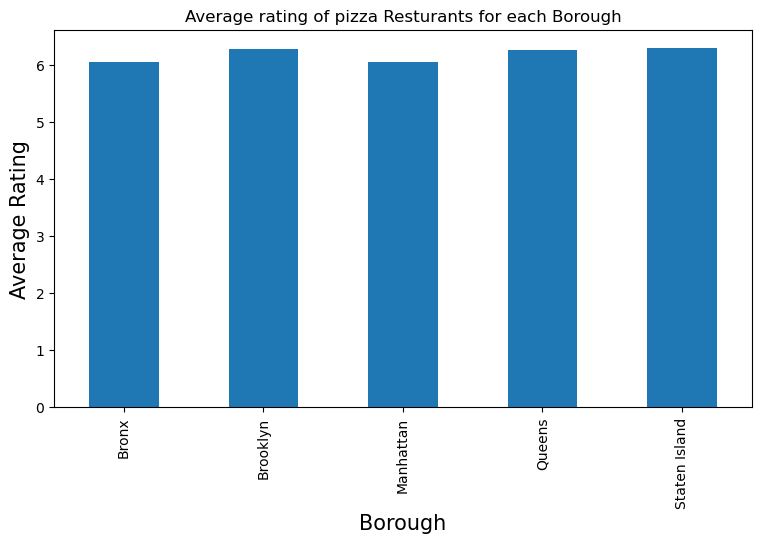

In [250]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of pizza Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
ny_borough_stats.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

### Top neighborhood with top average rating of pizza resturants

            Borough       Neighborhood                        ID  \
452        Brooklyn      Fort Hamilton  51d8a6428bbdc567c9a2442b   
316        Brooklyn        Cobble Hill  4ae10c7af964a520db8421e3   
257        Brooklyn           Flatbush  52f5554111d2e2288f611271   
921           Bronx         Mount Eden  4dd299f9d22d67839c5f6af0   
791   Staten Island           Annadale  58eea452e72ef631e9b864c8   
...             ...                ...                       ...   
404        Brooklyn         Ocean Hill  4d84ee7b40a7a35da1ee15be   
1015       Brooklyn            Erasmus  4d8cab34fe8d41bd573bd705   
947          Queens  Sunnyside Gardens  4ac77b97f964a5207cb720e3   
568          Queens           Flushing  4b7c7ddff964a5209c962fe3   
590          Queens            Maspeth  4e4dd054bd41b76bef938acb   

                          Name  Likes  Rating  
452              Nonno's Pizza  135.0     9.9  
316         My Little Pizzeria  112.0     9.9  
257       Little Caesars Pizza  164.0  

Text(0.5, 0, 'Borough')

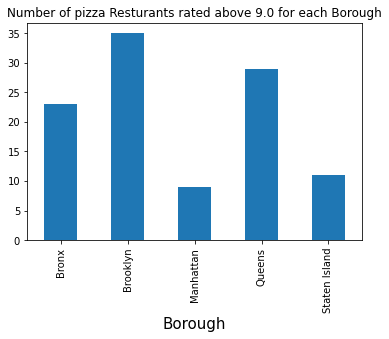

In [313]:
tempdf = df_pizza_nyc_stats.dropna().sort_values('Rating', ascending=False).copy(deep=True)
tempdf = tempdf[tempdf.Rating > 9.0]
print(tempdf)
tempdf.groupby('Borough')['ID'].count().plot(kind='bar')
plt.title('Number of pizza Resturants rated above 9.0 for each Borough')
plt.xlabel('Borough', fontsize = 15)

## Visualize neighborhoods with average rating greater or equal 5.0 on map

In [251]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=5.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Allerton,5.483333
1,Annadale,9.350000
3,Arrochar,9.900000
5,Astoria,7.200000
7,Auburndale,5.480000
...,...,...
271,Windsor Terrace,7.400000
273,Woodhaven,5.800000
274,Woodlawn,6.525000
275,Woodside,6.150000


In [254]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Allerton,5.483333
1,Annadale,9.350000
3,Arrochar,9.900000
5,Astoria,7.200000
7,Auburndale,5.480000
...,...,...
271,Windsor Terrace,7.400000
273,Woodhaven,5.800000
274,Woodlawn,6.525000
275,Woodside,6.150000


In [255]:
# join the dataframes
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_nyc_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Allerton,40.865788,-73.859319,5.483333
1,Staten Island,Annadale,40.538114,-74.178549,9.350000
2,Staten Island,Arrochar,40.596313,-74.067124,9.900000
3,Queens,Astoria,40.768509,-73.915654,7.200000
4,Queens,Auburndale,40.761730,-73.791762,5.480000
...,...,...,...,...,...
226,Brooklyn,Windsor Terrace,40.656946,-73.980073,7.400000
227,Queens,Woodhaven,40.689887,-73.858110,5.800000
228,Bronx,Woodlawn,40.898273,-73.867315,6.525000
229,Queens,Woodside,40.746349,-73.901842,6.150000


In [256]:
# create the map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

###  add a new field to dataframe for labeling purpose

In [257]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [266]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Let's analyze what we have found so far. 

### Conclusion


None of the boroughs can clain to be better than the others when it comes to pizza quality. All of them have an average rating of ~6. This is quite surprising. 

A look at the neighborhoods tells a differnt story. Brooklyn has got a bunch of very highly rated (>9) neighborhoods. However, its average score is brought down by the number of below average (<4) pizza places. Manhattan also has the smallest number of pizza places out of all five boroughs. However, given the the fact that the majority of highly rates pizza places are in Brooklyn, it is the pick of our analysis. This also serves as a business opportunity as a high quality pizza chain at budget cost could easily drive these businesses out. 

### Limitations

Our analysis based only on basis of rating of resturants. Crime and other social issues might impact this analysis. Data accuracy is dependent on FourSquare API. In short, don't base your house purchase based on this analysis. But feel free to use it to hunt for pizza in NYC. 

### That is all I have for my analysis.

## Thank you for reviewing it. 